

<div style='background-color: #567890; color:white; padding:15px;'>
    
### Проект по спринту «Машинное обучение для текстов»: <br>классификация комментариев с BERT

<br><br>
Интернет-магазин N запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
<br><br>
#### Цели работы

Обучить модель классифицировать комментарии на позитивные и негативные. Метрика качества F1 должна быть не меньше 0.75. 
<br><br>

#### План работы

1. Предобработка данных
2. Векторизация текстов
3. Исправление дисбаланса данных
4. Проверка датасета на лог. регрессии
5. Проверка на градиентном бустинге
6. Выводы по классическим моделям для текстов
7. Подготовка данных для модели BERT
8. Тренировочный и валидационный цикл модели BERT
10. Результаты по модели BERT
11. Проверка датасета на предобученной модели RoBERTa
12. Результаты по модели RoBERTa
13. Выводы по проекту


</div>

In [2]:
#importing standart libs
import os
import warnings
import re
import time as tm
import datetime
import random

#importing additional libs
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords as nltk_stopwords

# models and stuff
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.utils import resample

# import lightgbm
from lightgbm import LGBMClassifier

# neiro-things
import torch
import transformers
from torch.optim import AdamW
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from tqdm import notebook

<div style="border: 2px solid darkred; padding: 20px">
    Примечание: в такой конфигурации проект не будет считать данные моделями Берт и Роберта, но будет их инициализировать (в результате Робертой можно проверить любой текст в конце проекта). Если захочется проверить работу кода обучения\валидации, нужно указать False в параметрах SKIP_BERT, SKIP_ROBERTA
</div>

In [4]:
# configuration

DATA_PATH = './datasets/' # the datasets path
DATA_PATH_ALT = '/datasets/' # alternative path for reviewer
DATA_FILENAME = 'toxic_comments.csv'
RANDOM_STATE = 2042 # a random number for data shuffling to be constant
TEST_SIZE = 0.15
MIN_METRIC = 0.75 # min value of quality metric we need to achieve
RESEARCH_MODE = True # if True, we process only a small part of a dataset to speed up all the calcs
DATASET_SPLIT = 0.05 # which part of dataset we're processing in RESEARCH_MODE
SKIP_BERT = True # do we need to train&check BERT model?
SKIP_ROBERTA = True # do we need to skip cheking quality on RoBERTa model?
EPS = 1e-9 # a small number that helps to prevent 0_division

In [5]:
# pre-settings

pd.set_option('display.max_colwidth', None)
# switching off the warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [7]:
# datasets loading

try:
    if os.path.exists(DATA_PATH + DATA_FILENAME):
        path = DATA_PATH
    else:
        path = DATA_PATH_ALT
    tw = pd.read_csv(path + DATA_FILENAME)
except:
    print(f'Ошибка в загрузке датасетов! Проверьте, пожалуйста, что есть каталог {DATA_PATH} или {DATA_PATH_ALT}, в котором лежит файл {DATA_FILENAME}')

Выведем начало датасета и общую информацию о нём.

In [9]:
display(tw.head())
print(tw.info())

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


Большие датасеты приводят к значительным временным затратам при обсчитывании проекта. Поэтому во время разработки проекта мы будем использовать "исследовательский режим" - вместо полного датасета возьмём лишь его малую часть (в данном случае, 5%). Убедившись в работоспособности всего кода, мы проведём расчёты на полной выборке.<br>Отключить режим можно в разделе установки констант, задав значение <code>RESEARCH_MODE = False</code>

In [11]:
np.random.seed(RANDOM_STATE) # important one

In [12]:
if RESEARCH_MODE:
    idx_sample = np.random.randint(0, len(tw), size=round(len(tw)*DATASET_SPLIT))
    tw = tw.iloc[idx_sample]
else:
    DATASET_SPLIT = 1

> Важный момент для проверки: ниже выводятся числа, равны ли они 8047, 60175, 52784, 48837, 35695 ?

Если нет, нужно перезапускать расчёт эмбеддингов, а не считывать их из заранее рассчитанного файла

In [14]:
idx_sample[:5]

array([ 8047, 60175, 52784, 48837, 35695])

Дополнительная проверка - в каком режиме мы находимся? Размер полного датасета = 159292 значений.

In [16]:
tw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7965 entries, 8047 to 155309
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7965 non-null   int64 
 1   text        7965 non-null   object
 2   toxic       7965 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 248.9+ KB


### Предобработка данных

#### Приведение типов

Колонка <code>toxic</code> имеет излишне "увесистый" тип данных для значений 0 и 1. Изменим тип для оптимизации размера датасета.

In [20]:
tw['toxic'] = tw['toxic'].astype('uint8')

In [21]:
tw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7965 entries, 8047 to 155309
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7965 non-null   int64 
 1   text        7965 non-null   object
 2   toxic       7965 non-null   uint8 
dtypes: int64(1), object(1), uint8(1)
memory usage: 194.5+ KB


#### Очистка текста

Прежде всего, обратим внимание на колонку <code>Unnamed: 0</code> - она представляется лишней, индекс у нас есть. Удалим её.

In [24]:
tw = tw.drop('Unnamed: 0', axis=1)

В комментариях видим большое количество символов перевода строки <code>\n</code>. Нам они тоже не понадобятся.

In [26]:
tw['text'] = tw['text'].str.replace('\n', ' ')

Перед токенизацией удалим также стоп-слова и ненужные символы - для задачи классификации можно обойтись без цифр и пунктуации.<br>
Для этого напишем отдельные функции, а затем применим их к каждой ячейке столбца <code>text</code>.<br>Лемматизация (а также перевод в нижний регистр) нам не нужна, поскольку мы будем использовать продвинутую модель RuBert.

In [28]:
# stopwords loading from NLTK

nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def stopwords_removing(text: str, stopwords: list) -> str:
    '''
    -= a function that removes all the stopwords from given text =-
    '''
    filtered_words = [word for word in text.split() if word.lower() not in stopwords]
    return (" ".join(filtered_words))
    

In [30]:
def text_clearing(text: str) -> str:
    '''
    -= a function that removes all the symbols from given text exclude english and cyrillic letters,
    making text lowercased =-
    '''
    # getting rid of dates like '21:51, January 11, 2016 (UTC)'
    re_timedate = r"\d\d:\d\d..[A-Z]\w+\s\d\d..\d\d\d\d?(.\(\w+\))?"
    re_timedate_day_first = r"\d\d:\d\d..\d\d.[A-Z]\w+.\d\d\d\d.?(\(\w[A-Z]+\))?"
     
    text = re.compile(re_timedate).sub(' ', text)
    text = re.compile(re_timedate_day_first).sub(' ', text)
    
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ]', ' ', text).lower()
    return " ".join(text.split())


Последовательно убираем стоп-слова (в актуальной версии проекта может быть disabled, потому что большие модели в этом не нуждаются) и очищаем текст комментариев от лишнего.

In [32]:
# tw['text'] = tw['text'].apply(lambda x: stopwords_removing(x, stopwords=stopwords)).apply(text_clearing)

tw['text'] = tw['text'].apply(text_clearing)

Всё ли идёт хорошо? Выведем начало датасета.

In [34]:
tw.head()

,text,toxic
8047,this post placed here grazon who does not sign his her postings on wikipedia i don t understand what you mean political beliefs are you implying that i am taking the opposite side of this argument because harding is a republican ergo i feel the need to protect him i m sticking up for the man because i have looked at primary resources and know what they say and what they do not contain which is any inkling of klan involvement what i can t figure out is why is it so important for you include harding in the klan that you would base you whole argument on what one book claims,0
60175,notability tags please do not remove article tags without explanation and without addressing issues let me know if you have any questions as to how to do this,0
52784,love this page i ve just made several additions to farragher s boxing record on boxrec com another youngstown boxer who deserves a wiki page is squirrel finnerty,0
48837,you might want to have it more on his occultism he was heavy into seances and the such there are many of his plays that deal with the matter his understanding of time the soul and immortality are likewise interesting it would probably be best to come up with a separate page first and then summarize that page in a section william butler yeats s occultism something along that line,0
35695,felix lupa deleted page my name is vered sadot and i m a brand new user on you have deleted page i edited felix lupa a article about a real person which does not indicate the importance or significance of the subject if possible pls indicate what made you think that the subject wasn t significant or important the real person is a great street photographer in israel and worldwide such as other israeli photographers on list and more i would like to create a new page and do it right so i realy need your opinion x a lot,0


#### Токенизация

С помощью библиотеки transformers загрузим токенизатор для модели Bert.

Если мы уже проводили процедуры токенизации, добавления маски внимания и паддинга при текущем параметре DATASET_SPLIT, считаем полученный файл с результатами, что существенно ускорит исследовательский процесс.

In [37]:
tokenized_masked_padded = False

if os.path.exists('tokenized_masked_padded_x'+str(DATASET_SPLIT)+'.npy'):
    tokenized_masked_padded = True

    # saving to .csv messes with lists of nums, so we use numpy -> pd.DF
    tw = np.load('tokenized_masked_padded_x'+str(DATASET_SPLIT)+'.npy', allow_pickle=True)
    tw = pd.DataFrame(tw)
    tw.rename(columns={0:'text', 1: 'toxic', 2:'tokens', 3:'mask'}, inplace=True)
    tw['toxic'] = tw['toxic'].astype('uint8')

Токенизируем все наши тексты. Запишем токены в отдельную колонку.<br>Процедура на полном датасете займёт примерно 2,5 минуты.

In [39]:
%%time
if not(tokenized_masked_padded):
    
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    
    tw['tokens'] = tw['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

CPU times: total: 0 ns
Wall time: 0 ns


In [40]:
tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7825 entries, 0 to 7824
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7825 non-null   object
 1   toxic   7825 non-null   uint8 
 2   tokens  7825 non-null   object
 3   mask    7825 non-null   object
dtypes: object(3), uint8(1)
memory usage: 191.2+ KB


#### Паддинг

Длины всех токенизированных текстов должны быть равны, для того чтобы модель смогла работать. Поэтому осуществим процедуру padding - заполнение нулями недостающих до макс. значения позиций.<br>
Но сперва это максимальное значение (максимальная длина комментария в датасете) надо найти.

In [43]:
if not(tokenized_masked_padded):
    
    max_len = 0
    for i in range(tw.shape[0]):
        if len(tw.iloc[i]['tokens']) > max_len:
            max_len = len(tw.iloc[i]['tokens'])
            max_idx = i
    
    print(f'Максимальная длина комментария = {max_len} токенов')

Ради интереса посмотрим, что же это за пространное сочинение?

In [45]:
if not(tokenized_masked_padded):
    display(tw.iloc[max_idx])

Очень информативно, nice. ( ͡° ͜ʖ ͡°)

#### <i>Взгляд из будущего.</i>
При использовании модели BERT для векторизации выяснилось, что она принимает на вход не больше 512-и токенов за раз. Что можно с этим сделать?
- Разбивание входного вектора на отдельные части < 512 токенов кажется не рабочим методом для задачи классификации, ведь часть комментария, определяющая его токсичность, может оказаться в одном таком разбиении, а при этом все части разбиения получат одну оценку - оценку изначального, целого комментария (другой оценки у нас нет).
- Можно усекать длинные комментарии до размера 512 (прямо в токенизаторе для этого есть параметры <code>truncation</code> и <code>max_length</code>) токенов. Против этого аналогичные аргументы - что если токсичная часть находится за пределами 512-го токена? Модель обучится не тому.
- Длинные комментарии можно выбросить из датасета. Кажется единственно подходящим вариантом, который не снизит качество модели - но только если не сильно уменьшит размер датасета.
- Применение более продвинутой модели, допускающей большее количество входных признаков. Но здесь могут быть проблемы при валидации проекта ревьюером на окружении Я.Практикума, вплоть до невозможности проверки.


Попробуем для начала подсчитать количество комментариев, которые в токенизированном виде длиннее 512-и токенов. Сделаем это для полного датасета; если "текстовый" вывод отличается от результата исполнения кода - вы в "исследовательском" режиме.

In [48]:
%%time

if not(tokenized_masked_padded):
    
    max_len = 512
    cnt = 0
    idx_long_comments = []
    
    for i in range(len(tw['tokens'])):
        if len(tw.iloc[i]['tokens']) > max_len:
            cnt += 1
            idx_long_comments.append(tw.iloc[i].name)    
        
    print(f'Количество комментариев, которые длиннее {max_len} токенов = {cnt}')
    print(f'Процент "длинных" комментариев в датасете: {cnt/tw.shape[0]:.2%}')

CPU times: total: 0 ns
Wall time: 996 μs


> Количество "длинных" комментариев = 2433, что составляет всего полтора процента от полного датасета. Их можно безболезненно удалить.

In [50]:
# deleting 'long' comments
if not(tokenized_masked_padded):
    print('Размерность датасета до удаления =', tw.shape)
    tw = tw.drop(idx_long_comments, axis=0)
    print('Размерность датасета после удаления =', tw.shape)

Возвращаемся к главной задаче этого этапа: превратим все токенизированные комментарии в объекты с одинаковой длиной (теперь эта длина не превысит 512 токенов), "недостающие" "слова" заполним нулями.

In [52]:
if not(tokenized_masked_padded):
    tw['tokens'] = tw['tokens'].apply(lambda x: np.array(x + [0]*(max_len - len(x))))

Всё ли в порядке?

In [54]:
tw[:3]

,text,toxic,tokens,mask
0,this post placed here grazon who does not sign his her postings on wikipedia i don t understand what you mean political beliefs are you implying that i am taking the opposite side of this argument because harding is a republican ergo i feel the need to protect him i m sticking up for the man because i have looked at primary resources and know what they say and what they do not contain which is any inkling of klan involvement what i can t figure out is why is it so important for you include harding in the klan that you would base you whole argument on what one book claims,0,"[101, 2023, 2695, 2872, 2182, 26918, 2239, 2040, 2515, 2025, 3696, 2010, 2014, 14739, 2015, 2006, 16948, 1045, 2123, 1056, 3305, 2054, 2017, 2812, 2576, 9029, 2024, 2017, 20242, 2008, 1045, 2572, 2635, 1996, 4500, 2217, 1997, 2023, 6685, 2138, 15456, 2003, 1037, 3951, 9413, 3995, 1045, 2514, 1996, 2342, 2000, 4047, 2032, 1045, 1049, 13423, 2039, 2005, 1996, 2158, 2138, 1045, 2031, 2246, 2012, 3078, 4219, 1998, 2113, 2054, 2027, 2360, 1998, 2054, 2027, 2079, 2025, 5383, 2029, 2003, 2151, 10710, 2989, 1997, 26613, 6624, 2054, 1045, 2064, 1056, 3275, 2041, 2003, 2339, 2003, 2009, 2061, 2590, 2005, 2017, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"
1,notability tags please do not remove article tags without explanation and without addressing issues let me know if you have any questions as to how to do this,0,"[101, 2025, 8010, 22073, 3531, 2079, 2025, 6366, 3720, 22073, 2302, 7526, 1998, 2302, 12786, 3314, 2292, 2033, 2113, 2065, 2017, 2031, 2151, 3980, 2004, 2000, 2129, 2000, 2079, 2023, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,love this page i ve just made several additions to farragher s boxing record on boxrec com another youngstown boxer who deserves a wiki page is squirrel finnerty,0,"[101, 2293, 2023, 3931, 1045, 2310, 2074, 2081, 2195, 13134, 2000, 2521, 29181, 5886, 1055, 8362, 2501, 2006, 3482, 2890, 2278, 4012, 2178, 2402, 13731, 10423, 2040, 17210, 1037, 15536, 3211, 3931, 2003, 18197, 9303, 15010, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


C помощью следующего кода можно удостовериться, что теперь любой токенизированный комментарий имеет фиксированную длину:

In [56]:
token_index = 84
print(f"Комментарий № {token_index}, будучи токенизированным с паддингом, имеет длину {len(tw['tokens'].iloc[token_index])} ток.")

Комментарий № 84, будучи токенизированным с паддингом, имеет длину 512 ток.


#### Маскирование

После того, как мы добавили нулевые значения в токенизированные комментарии, нам нужно задать для каждого такого комментария <i>маску</i> - вектор длиной ровно с токенизированный комментарий, который будет указывать, значащий ли токен на соответствующем месте (1), или не значащий (0).<br>
Здесь нас в очередной раз выручит лямбда-функция, с помощью которой мы пробежимся по каждой ячейке колонки <code>tokens</code> и создадим в новой колонке <code>mask</code> np.array с единицей, если соответствующий токен не равен нулю - и нулём в обратном случае.<br><br>
И на этом этапе мы уже можем записывать обработанный корпус в файл, чтобы не проделывать все процедуры заново при каждом запуске проекта.

In [59]:
%%time
if not(tokenized_masked_padded):
    tw['mask'] = tw['tokens'].apply(lambda x: (x != 0).astype('int8'))

    # saving our results to not calculate all of those from scratch
    try:
        np.save('tokenized_masked_padded_x'+str(DATASET_SPLIT)+'.npy', tw.to_numpy())
    except:
        print('Не получилось записать данные обработки текстов. Возможно, нет разрешения на запись в данном месте')

CPU times: total: 0 ns
Wall time: 0 ns


Всё прошло успешно, и наконец-то у нас есть все данные для векторизации!

In [61]:
tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7825 entries, 0 to 7824
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7825 non-null   object
 1   toxic   7825 non-null   uint8 
 2   tokens  7825 non-null   object
 3   mask    7825 non-null   object
dtypes: object(3), uint8(1)
memory usage: 191.2+ KB


### Эмбеддинги (векторизация текстов через BERT)

#### Инициализация модели Bert

Пути до конфига модели и до самой модели, взятые из теории в Практикуме, никуда не привели при попытке работать с ними локально:
<br><code> <Error> NoSuchKey
<Message>The specified key does not exist.</Message>
...
</Error></code>Практикум такой Практикум (◣ _ ◢)<br><br>
С другой стороны, RuBERT не предназначен для работы с английскими текстами, а у нас комментарии на english. Пришлось искать обходные пути - мы взяли конфиг и модель из Huggingface.   

In [65]:
bert_config_dict = transformers.BertConfig()

In [66]:
bert_config_dict

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [67]:
model = transformers.BertModel.from_pretrained(pretrained_model_name_or_path='google-bert/bert-base-uncased', config=bert_config_dict)

#### Векторизация

Для ускорения вычислений перенесём модель на GPU, если возможно (для этого нужно сперва установить драйвера CUDA).<br>
В нашем случае обсчёт ускоряется в шесть раз!

In [70]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [71]:
print('Какой тип устройства доступен (если cuda, то доступно вычисление на GPU):')
print(device)

Какой тип устройства доступен (если cuda, то доступно вычисление на GPU):
cuda


In [72]:
model = model.to(device)

In [73]:
%%time

# если мы ещё не записывали фичи, то просчитаем эмбеддинги
if not(os.path.exists('features_x'+str(DATASET_SPLIT)+'.npy')):
        
    batch_size = 5
    # пустой список для хранения эмбеддингов комментариев
    embeddings = []
    batch_num = tw.shape[0] // batch_size
    for i in notebook.tqdm(range(batch_num)):
        bottom = batch_size*i
        batch = torch.LongTensor(tw[bottom:bottom+batch_size]['tokens'].reset_index(drop=True))
        attention_mask_batch = torch.LongTensor(tw[bottom:bottom+batch_size]['mask'].reset_index(drop=True))
        # данные должны быть на том же девайсе, где и модель, GPU или CPU
        batch = batch.to(device)
        attention_mask_batch = attention_mask_batch.to(device)
    
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        
        # printing some info every 20th batch since 'tqdm' doesn't work
        if i % 25 == 0:
            if i == 0:
                print(f'Из {batch_num} обработан батч №', i, end=" - ")
            else:
                print(i, end=' - ')
    
    # объединив эмбеддинги, получим набор фичей
    features = np.concatenate(embeddings)
    # запишем результат в файл, чтобы не ждать много минут в след. раз
    try:
        np.save('features_x'+str(DATASET_SPLIT), features)
    except:
        print('Не получилось записать данные обработки текстов. Возможно, нет разрешения на запись в данном месте')
        
# иначе считаем их из файла
else:
    features = np.load('features_x'+str(DATASET_SPLIT)+'.npy')

CPU times: total: 15.6 ms
Wall time: 8.98 ms


In [74]:
features.shape

(7825, 768)

> Иными словами, теперь каждый наш текстовый комментарий представляет собой набор из 768-и входных признаков - цифровых эмбеддингов. Дальше можно проводить с ними привычные операции, обучать модели на них и т. п.

### Простая логистическая регрессия

Для простоты разбиения датасета на тренировочную и тестовую часть соединим выходные признаки с целевой переменной (некоторую часть таргета придётся отрезать - количество сэмплов фичей пропорционально размеру батча, и какая-то часть из входных сэмплов осталась не-векторизированной).

In [78]:
features.shape

(7825, 768)

In [79]:
tw.shape

(7825, 4)

In [80]:
ds_combined = np.concatenate([features, tw['toxic'][:len(features)].to_numpy().reshape(-1, 1)], axis=1)

In [81]:
# мешаем датасет, потому что дальше возьмём выборку просто как часть датасета, не рандомно
np.random.shuffle(ds_combined)

Забежим немного вперёд. Дальше нам придётся исправлять дисбаланс в данных, создавая несколько искусственную выборку. Для её проверки полезно отложить какую-то часть от исходного распределения, чем ниже мы и займёмся.

Определим часть датасета под отложенную выборку, пусть это будет 8% от неё.

In [83]:
valid_num = round(len(ds_combined)*0.08)

In [84]:
ds_validation = ds_combined[0:valid_num]
ds_combined = ds_combined[valid_num:]

In [85]:
ds_validation.shape

(626, 769)

Какова теперь размерность входных признаков и объединённого датасета для обучения?

In [87]:
features.shape

(7825, 768)

In [88]:
ds_combined.shape

(7199, 769)

Всё правильно, добавился один "столбец" с таргетом, убавились "строки" под отложенную выборку.<br>

...а дальше мы столкнулись с проблемой в данных, которую нужно было исправлять. 

#### Несбалансированность датасета

Дело в том, что в датасете наблюдается сильный дисбаланс классов - отметок "1" в семь раз меньше, чем отметок "0".<br>
В результате модель сильно приучается выдавать прогнозы мажорного класса - метрика accuracy при этом может быть очень высокой, но в реальности число ответов false positive \ false negative (в зависимости от того, какой именно класс мажорный, то есть превалирующий) будет очень велико. Метрики типа F1 тогда будут околонулевыми, а roc-auc - в районе 0.5 (случайное угадывание).


Можно снизить влияние фактора разбалансировки, включив параметр <code>stratify</code> при разбиении на тренировочный и тестовый датасеты. Однако, это не помогло, и нам нужно пробовать более "сильные" способы борьбы с дисбалансом - такие как добавление количества сэмплов минорного класса (upsampling) и удаление сэмплов мажорного класса (downsampling).

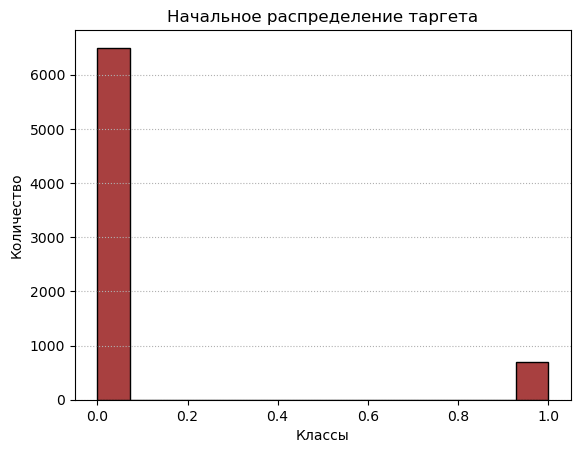

In [92]:
# yes I'm using histplot here

ax = sns.histplot(ds_combined[:, -1], color='darkred')
ax.grid(linestyle=":", axis='y')
ax.set_title('Начальное распределение таргета')
ax.set_ylabel('Количество')
ax.set_xlabel('Классы');

In [93]:
zero_labels_num = len(ds_combined[ds_combined[:, -1] == 0])
one_labels_num = len(ds_combined[ds_combined[:, -1] == 1])

In [94]:
print(f'Сэмплов класса "0" в {zero_labels_num / one_labels_num:.1f} раз больше сэмплов класса "1"')

Сэмплов класса "0" в 9.3 раз больше сэмплов класса "1"


- Исследуем оба подхода.

Делаем сэмплирование:

In [97]:
# for upsampling
ds_resampled = resample(ds_combined[ds_combined[:, -1] == 1], n_samples=zero_labels_num-one_labels_num, random_state=RANDOM_STATE)

# for downsampling
# ds_resampled = resample(ds_combined[ds_combined[:, -1] == 0], n_samples=one_labels_num,
#                         replace=False, random_state=RANDOM_STATE)

Объединяем с исходными данными:

In [99]:
# upsampling
ds_combined = np.vstack((ds_combined, ds_resampled))

# downsampling
# ds_combined = np.vstack((ds_combined[ds_combined[:, -1] == 1], ds_resampled))

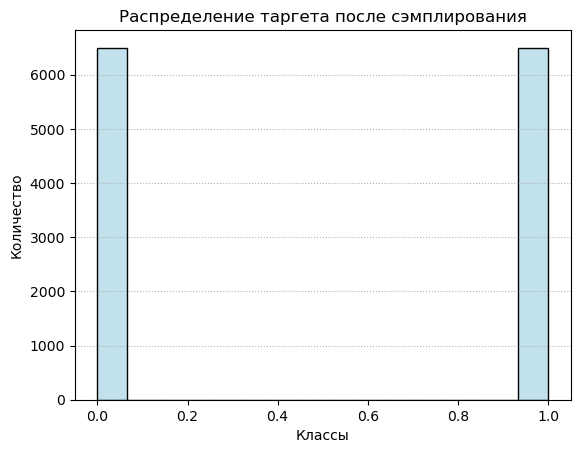

In [100]:
ax = sns.histplot(ds_combined[:, -1], color='lightblue')
ax.grid(linestyle=":", axis='y')
ax.set_title('Распределение таргета после сэмплирования')
ax.set_ylabel('Количество')
ax.set_xlabel('Классы');

- Забегая вперёд - upsampling показал значительно лучшие результаты, но есть нюансы.

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    ds_combined[:, :-1], ds_combined[:, -1], stratify=ds_combined[:, -1],
    test_size=TEST_SIZE, random_state=RANDOM_STATE
)

Проверим размерности получившихся датасетов.

In [104]:
print('Размерности тренировочных датасетов с фичами и таргетом:', '💪', X_train.shape, '|', y_train.shape)
print('Размерности тестовых датасетов с фичами и таргетом:', '✅', X_test.shape, '|', y_test.shape)

Размерности тренировочных датасетов с фичами и таргетом: 💪 (11044, 768) | (11044,)
Размерности тестовых датасетов с фичами и таргетом: ✅ (1950, 768) | (1950,)


#### Логрег с исправленным дисбалансом

In [106]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       975
         1.0       0.93      0.99      0.96       975

    accuracy                           0.96      1950
   macro avg       0.96      0.96      0.96      1950
weighted avg       0.96      0.96      0.96      1950



Удовлетворяет ли ТЗ метрика F1?

In [108]:
print(f1_score(y_test, preds))

0.9587680079483358


In [109]:
if f1_score(y_test, preds) < MIN_METRIC:
    print('Метрика F1 меньше требуемой')
else:
    print('Условия ТЗ выполнены! Метрика F1 больше', MIN_METRIC)

Условия ТЗ выполнены! Метрика F1 больше 0.75


##### Проверка на отложенной выборке

In [111]:
preds_valid_ = logreg.predict(ds_validation[:, :-1])

In [112]:
f1_score(ds_validation[:, -1], preds_valid_)

0.6666666666666666

In [113]:
print(classification_report(ds_validation[:, -1], preds_valid_))

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       551
         1.0       0.56      0.81      0.67        75

    accuracy                           0.90       626
   macro avg       0.77      0.86      0.80       626
weighted avg       0.92      0.90      0.91       626



> Простая логистическая регрессия не даёт нужного результата по метрике, если ориентироваться на отложенную выборку

### Деревья на градиентном бустинге

В этом классе моделей мы будем использовать Light Gradient Boosted Machine (LightGBM). Параметры зададим произвольно.

In [117]:
lgbm = LGBMClassifier(n_estimators = 150, max_depth = 10)

In [118]:
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 5522, number of negative: 5522
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 11044, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(max_depth=10, n_estimators=150)

In [119]:
preds = lgbm.predict(X_test)

In [120]:
f1_score(y_test, preds)

0.9913573970513472

In [121]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       975
         1.0       0.98      1.00      0.99       975

    accuracy                           0.99      1950
   macro avg       0.99      0.99      0.99      1950
weighted avg       0.99      0.99      0.99      1950



Удовлетворяет ли ТЗ метрика F1?

In [123]:
if f1_score(y_test, preds) < MIN_METRIC:
    print('Метрика F1 меньше требуемой')
else:
    print('Условия ТЗ выполнены! Метрика F1 больше', MIN_METRIC)

Условия ТЗ выполнены! Метрика F1 больше 0.75


> Модель на градиентном бустинге даже без подбора параметров показывает очень высокий результат, подходящий нам по ТЗ.
>
> <u>Однако не стоит доверять этому результату, потому что он получен на части синтетических данных</u>. Более правильным подходом всё же видится downsampling

In [125]:
preds_valid = lgbm.predict(ds_validation[:, :-1])

In [126]:
f1_score(ds_validation[:, -1], preds_valid)

0.6470588235294118

In [127]:
print(classification_report(ds_validation[:, -1], preds_valid))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       551
         1.0       0.72      0.59      0.65        75

    accuracy                           0.92       626
   macro avg       0.83      0.78      0.80       626
weighted avg       0.92      0.92      0.92       626



### Сводная таблица с метрикой F1

| Модель, размер датасета | Тестовые сэмплированные данные | Отложенная выборка вне сэмплирования |
|:---------|:--------:|:--------------------------------------------:|
|Logistic Regression, 1% |  0.96  | 0.71|
|Logistic Regression, 5% |  0.95  |  0.61 |
|Logistic Regression, 20%| 0.9 | 0.6 |
|Logistic Regression, 95%|0.89|0.63|
|LGBMClassifier, 1% |0.98|0.45|
|LGBMClassifier, 5% |0.99|0.65|
|LGBMClassifier, 20% |  0.98   |  0.75  |
|LGBMClassifier, 95% |0.95|0.71|


### Вывод по применению классических моделей

Не стоит слишком доверять около-идеальному значению метрики на сэмплированных данных, всё же это несколько искусственные выборки. На реальных данных мы скорее увидим примерно такие значения F1, как в расчётах с отложенной выборкой. Нас, как дата-сайентистов, подобные показатели устраивать не могут. Можно, конечно, устроить подбор параметров по GridSearch и выбить нужные значения метрики качества...

Но что, если посмотреть, какие результаты покажут специально предназначенные для работы с текстом нейро-модели?

### Использование модели BERT для классификации

Одна из главных непонятностей этого проекта заключается в том, а зачем мы вообще возимся с эмбеддингами, чтобы применить их в "классических" моделях машинного обучения. В реальной жизни специалисты скорее возьмут одну из существующих свободно-распространяемых моделей глубокого обучения, до-обучат её на собранном под их задачу датасете и будут успешно применять. Однако в нашей теории нет ничего такого, и, например, архитектура трансформеров - одна из основ в NLP - совсем не затронута.

Чтобы извлечь хоть какую-то пользу из этого проекта, мы решили включить режим самообучения, и попробовать решить стоящую задачу непосредственно на BERT'e.

Это довольно сложная задача для начинающего data scientist'а без опыта работы (и даже учёбы) с нейронками, поэтому основную часть кода для обучения и валидации мы взяли здесь: https://mccormickml.com/2019/07/22/BERT-fine-tuning/#4-train-our-classification-model, исправив вылезшие ошибки и поменяв метрику качества.

#### Исправление дисбаланса. Смещённый downsampling

На этот раз применим немного более хитрую схему - мы не будем уравнивать количество сэмплов обоих классов через downsampling, а возьмём чуть бóльшую долю превалирующего класса. Наша интуиция в том, что такое выравнивание более точно воспроизведёт реальную ситуацию на реальных данных, ведь если модель обучится на данных с равным количеством классов, а в продакшне будет получать сильный дисбаланс, она вряд ли покажет себя хорошим прогнозатором. Мы назвали эту схему "выравнивание со смещением".<br>
"Смещение" задаётся параметром BALANCE_SHIFT. Например, если этот параметр равен 1.5, то после downsampling количество сэмплов мажорного класса будет в 1.5 больше количества сэмплов минорного класса.

N. B. видится логичным задавать смещение как долю от реального коэффициента дисбаланса, но чтобы соотношение количества сэмплов разных классов было, к примеру, не больше 1.5-1.9, но ниже мы реализуем просто "константный" подход.

In [138]:
def shifted_downsampling(data: pd.DataFrame, class_col: str, 
                         balance_shift: float, shuffle: bool=True) -> pd.DataFrame:
    '''
    Downsampling for binary classification tasks with number of major class samples = N * number of 
    minor class samples, where N is 'balance_shift' variable.
    
    'class_col' - name of column with classes labels;
    'shuffle' - if False, resulting dataset will not be shuffled, making it look like
                it's sorted by column 'class_col';
                
    '''
    
    one_labels_num = (data[class_col] == 1).sum()
    zero_labels_num = (data[class_col] == 0).sum()
    
    imbalance_coef = zero_labels_num / one_labels_num
    
    if zero_labels_num < one_labels_num:
        major_class = 1
        minor_labels_num = zero_labels_num
    else:
        major_class = 0
        minor_labels_num = one_labels_num

    num_samples = round(balance_shift*minor_labels_num)
    if num_samples > len(data[data[class_col] == major_class]):
        return(f'Too few data to resample with balance_shift = {balance_shift}')
    
    resampled = resample(data[data[class_col] == major_class], n_samples=num_samples,
                            replace=False, random_state=2042)
    
    data = pd.concat((data[data[class_col] == 1 - major_class], resampled), axis=0)

    # at this moment we have first part of DS of minor class, second part - major
    # it's better to shuffle these data by default
    if shuffle:
        data = data.sample(frac = 1, replace=False)
    
    return(data)

Производим downsampling и выводим некоторые цифры для проверки.

In [140]:
tw = shifted_downsampling(tw, 'toxic', 1.5)

In [141]:
tw['toxic'].value_counts()

toxic
0    1166
1     777
Name: count, dtype: int64

In [142]:
print('Размер после downsampling со смещением:', tw.shape)

Размер после downsampling со смещением: (1943, 4)


#### Подготовка данных под формат, требуемый моделью

Для использования модели BERT наши данные должны иметь формат тензоров, а пока у нас отдельные числа (отметка токсичности) и списки с цифрами (исходные комментарии в виде токенов и маска внимания). Исправим это.

In [145]:
tensor_tokens = torch.LongTensor(np.vstack(tw['tokens']))
tensor_masks = torch.LongTensor(np.vstack(tw['mask']))
tensor_labels = torch.LongTensor(np.array(tw['toxic']))

In [146]:
tensor_labels.dtype, tensor_labels.shape

(torch.int64, torch.Size([1943]))

In [147]:
tensor_tokens.shape

torch.Size([1943, 512])

Создадим специальный PyTorch датасет, объединяя данные и разметку классов. 

In [149]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(tensor_tokens, tensor_masks, tensor_labels)

Разбиваем на тренировку и тест, как обычно. Только теперь используем метод не из Sklearn, а из PyTorch.

In [151]:
train_dataset, test_dataset = random_split(dataset, [1 - TEST_SIZE, TEST_SIZE])

print('Количество сэмплов в тренировочной части:', len(train_dataset))
print('Количество сэмплов в тестовой части:', len(test_dataset))

Количество сэмплов в тренировочной части: 1652
Количество сэмплов в тестовой части: 291


Дальше создаются загрузчики данных - экземпляры специального класса DataLoader, которые будут подгружать в модель данные частями = батчами, чтобы наша память не взорвалась. Размер такого куска задаём в переменной batch_size.

N. B. Батчи длиннее восьми наше железо не выдерживает

In [153]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            shuffle=False,
            # sampler = RandomSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#### Инициализация модели

Дальше инициализируем модель <code>BertForSequenceClassification</code>, предназначенную ровно под наш тип задач

In [156]:
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.BCELoss()

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model_classify = transformers.BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# переносим модель на доступный 'девайс'
model_classify = model_classify.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [157]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

#### Основная часть - тренировочный и валидационный цикл

In [159]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [160]:
# calculating custom F1 (harmonic mean of precision and recall)

def f1_custom(tp: int, fp: int, fn: int) -> float:
    '''
    Compute F1 score using numbers of True, False positive and False negative.
     
    '''
    precision = tp / (tp + fp + EPS)
    recall = tp / (tp + fn + EPS)
    return 2*precision*recall / (precision + recall + EPS)

In [161]:
# Set the seed value all over the place to make this reproducible.

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = tm.time()

if not(SKIP_BERT):

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.
    
        print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
    
        # Measure how long the training epoch takes.
        t0 = tm.time()
    
        # Reset the total loss for this epoch.
        total_train_loss = 0
    
        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model_classify.train()
    
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
    
            # Progress update every ... batches.
            if step % 30 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(tm.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,} of {:>4,}.   Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
    
            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            
            # model_classify.zero_grad()
            # в других источниках оптимайзер обнуляют. будет ли разница?
            optimizer.zero_grad()
            
            # Perform a forward pass (evaluate the model on this training batch).
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our usage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
                      
            outputs = model_classify(input_ids=b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask,
                                 labels = b_labels
                                 )
            #this loss worked ok, we've tried another one below
            loss = outputs[0]
    
            pred = torch.sigmoid(outputs[1][:, 1]).detach().cpu()
            tru = torch.tensor(b_labels.to('cpu'))
            # loss = loss_fn(pred, torch.FloatTensor(tru*1.0))
         
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            
            total_train_loss += loss.item()
            
            # Perform a backward pass to calculate the gradients.
            # loss.requires_grad = True
            loss.backward()
    
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model_classify.parameters(), 1.0)
    
            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()
    
            # Update the learning rate.
            scheduler.step()
    
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        loss_plot.append(avg_train_loss)
        
        # Measure how long this epoch took.
        training_time = format_time(tm.time() - t0)
    
        print("\n   Average training loss: {0:.2f}".format(avg_train_loss))
        print("   Training epoch took: {:}".format(training_time))
    
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
    
        print("\nRunning Validation...")
    
        t0 = tm.time()
    
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model_classify.eval()
    
        # Tracking variables 
        total_eval_loss = 0
        TP, FP, FN = 0, 0, 0
    
        # Evaluate data for one epoch
        for step, batch in enumerate(test_dataloader):
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
    
                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                outputs = model_classify(
                                input_ids = b_input_ids, 
                                token_type_ids = None, 
                                attention_mask = b_input_mask,
                                labels = b_labels
                                )
    
            logits = outputs[0]
            # Accumulate the validation loss.
            total_eval_loss += logits.item()
    
            # Move logits and labels to CPU
            logits = logits.detach().cpu()
            label_ids = b_labels.to('cpu')
            
            y_pred = torch.max(outputs[1].cpu(), axis=1)[1]
            y_true = label_ids
    
            tp = ((y_pred == 1) & (y_true == 1)).sum().numpy()
            fp = ((y_pred == 1) & (y_true == 0)).sum().numpy()
            fn = ((y_pred == 0) & (y_true == 1)).sum().numpy()
    
            TP += tp
            FP += fp
            FN += fn
    
            if step % 10 == 0 and step !=0:
                print('  Batch {:>4,}  of  {:>4,}'.format(step, len(test_dataloader)))
    
       
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(test_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(tm.time() - t0)
    
        metric_f1 = f1_custom(TP, FP, FN)
    
        print("\n   F1-score: {0:.2f}".format(metric_f1))
        print("   Validation Loss: {0:.2f}".format(avg_val_loss))
        print("   Validation took: {:}".format(validation_time))
    
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Training Time': training_time,
                'Validation Time': validation_time,
                'F1-score': metric_f1
            }
        )
    
    print("\nTraining complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(tm.time()-total_t0)))

In [162]:
#torch.save(model.state_dict(), 'trained_model_x'+str(DATASET_SPLIT)+'.pt')
#model.save_pretrained('trained_model_x') 

#### Промежуточные итоги

На несбалансированном датасете размером в 0.01 (1%) от оригинала BERT показывает метрику F1 = 0.21 на валидационной части. Уже чуть лучше, классические модели показывали 0 (ноль). Но главное другое - <u>спустя бессчётное количество итераций нам наконец-то удалось заставить работать трен. и валидационные циклы</u>. Теперь можно ставить эксперименты.

#### Важное примечание

Наш второй цикл - после тренировочного - называется <i>валидационным</i>, но по сути мы используем разбиение датасета только на две выборки - тренировочную и тестовую. Можно выделять и третью выборку, и потом проводить её через такой же цикл, как валидационный, и показатели качества на ней учитывать как финальные, но это увеличит количество кода, и к тому же мы не проводим тюнинг гипер-параметров.

#### Таблица с результатами классификации c BERT

Ниже приведено максимальное значение метрики F1 для различного объёма данных из датасета.

| Размер датасета | Исходные данные | Данные без дисбаланса |Баланс+оставление стоп-слов| Время обучения, ч:мм |
|:---------|:--------:|:---------:|:---------:|:---------:|
|1% |  0.21 |0.49|0.58| 0:09 |
|5% | 0.05   |0.57||1:25 |
|20%| 0.19 | 0.45 |0.55|3:56|
|95%|||0.54|4:43|


#### Вывод по использованию BERT

Видим, что метрика в данных без исправленного дисбаланса хуже, и ещё и нестабильнее. Поэтому следует исправлять дисбаланс.
<br>
Интересно также, что <i>неудаление</i> стоп-слов улучшает метрику почти на 10%! BERT продвинутый, подобная чистка ему не нужна.<br><br>
Средний лосс на тренировке составляет около 0.9 и практчески не изменяется от эпохи к эпохе, как и метрика качества, то есть проводить больше 2-х эпох не имеет смысла (1 эпоха длилась около 3,5 часов, а 3 эпохи - 11 часов).
<br><br>
Плохо то, что <u>на том же объёме данных мы не получаем качества лучше, чем у классических моделей</u>, при том, что работают они на порядки быстрее. <b>Метрика F1 не достигла даже 0.6</b>. Возможно, имеющийся датасет слишком мал, чтобы LLM могли показать себя в полную мощь - в максимуме модель обучалась на 34628 сэмплах, а тестировалась на 6110.<br>
Либо мы что-то делаем не так.

### Предобученная модель RoBERTa toxicity classifier

Возможно, нас выручит модель, обученная ровно под нашу задачу. Это классификатор токсичности сообщений, основанный на модели RoBERTa (один из многих улучшенных вариантов BERT).<br>
С моделью можно ознакомиться здесь: https://huggingface.co/s-nlp/roberta_toxicity_classifier

In [174]:
# Load model directly
tokenizer = transformers.RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')
model_roberta = transformers.AutoModelForSequenceClassification.from_pretrained("s-nlp/roberta_toxicity_classifier")

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> Мы уже исправляли дисбаланс в датафрейме <code>tw</code> (см. раздел с BERT "Исправление дисбаланса"), поэтому делать это заново не нужно. Убедимся только, что всё точно сохранилось.

In [176]:
tw['toxic'].value_counts()

toxic
0    1166
1     777
Name: count, dtype: int64

#### Токенизация

В первоисточнике предлагается не тот же токенизитор, что мы использовали для BERT. Он выдаёт другие токены, нам нужно заново токенизировать тексты.

Если мы уже проводили процедуры токенизации, добавления маски внимания и паддинга, считаем полученный файл с результатами, что существенно ускорит исследовательский процесс.

In [179]:
rb_tokenized_masked_padded = False

if os.path.exists('rb_tokenized_masked_padded_x'+str(DATASET_SPLIT)+'.npy'):
    rb_tokenized_masked_padded = True

    # saving to .csv messes with lists of nums, so we use numpy->pd.DF
    roberta_df = np.load('rb_tokenized_masked_padded_x'+str(DATASET_SPLIT)+'.npy', allow_pickle=True)
    roberta_df = pd.DataFrame(roberta_df)
    roberta_df.rename(columns={0:'text', 1: 'tokens', 2:'mask', 3:'label'}, inplace=True)
    roberta_df['label'] = roberta_df['label'].astype('uint8')

Сделаем отдельный датафрейм для этой модели.<br>

В процессе исследования мы выяснили, что токенизаторы умеют сами достраивать паддинг и делать маску внимания. Воспользуемся этим для ускорения и чистоты кода.

In [181]:
%%time
if not(rb_tokenized_masked_padded):
    
    roberta_df = pd.DataFrame(index=range(len(tw)), columns=['text', 'tokens', 'mask', 'label'])
    
    for line, text in enumerate(tw['text']):

        tkn = tokenizer(text, max_length=512, padding='max_length', padding_side='right', truncation=True)
        roberta_df['tokens'].iloc[line] = tkn['input_ids']
        roberta_df['mask'].iloc[line] = tkn['attention_mask']
        roberta_df['label'].iloc[line] = tw['toxic'].iloc[line]
        roberta_df['text'].iloc[line] = tw['text'].iloc[line]
       

    # saving our results to not calculate all of those from scratch
    try:
        np.save('rb_tokenized_masked_padded_x'+str(DATASET_SPLIT)+'.npy', roberta_df.to_numpy())
    except:
        print('Не получилось записать данные обработки текстов. Возможно, нет разрешения на запись в данном месте')
        

CPU times: total: 0 ns
Wall time: 0 ns


In [182]:
roberta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943 entries, 0 to 1942
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1943 non-null   object
 1   tokens  1943 non-null   object
 2   mask    1943 non-null   object
 3   label   1943 non-null   uint8 
dtypes: object(3), uint8(1)
memory usage: 47.6+ KB


- Все данные для модели нужно преобразовать в тензоры

In [184]:
tensor_tokens = torch.LongTensor(np.vstack(roberta_df['tokens']))
tensor_masks = torch.LongTensor(np.vstack(roberta_df['mask']))
tensor_labels = torch.LongTensor(np.array(roberta_df['label'].astype('int')))

- Создадим специальный PyTorch датасет, объединяя данные и разметку классов. 

In [186]:
# Combine the all inputs into a TensorDataset.
dataset = TensorDataset(tensor_tokens, tensor_masks, tensor_labels)

batch_size = 8

# we don't need to train and validate this model, so all the data is feeding now
all_data_dataloader = DataLoader(
            dataset,
            sampler = RandomSampler(dataset),
            batch_size = batch_size
        )

In [187]:
# sending our model to device
model_roberta.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

Для получения предсказаний по всему датасету, а затем замера метрик на них, сделаем такой же цикл, как и валидационный цикл для BERT.

In [189]:
TP, FP, FN = 0, 0, 0
total_eval_loss = 0
t0 = tm.time()

if not(SKIP_ROBERTA):
    print('\n======== Считаем качество на предобученной модели RoBERTa ========')
    
    for step, batch in enumerate(all_data_dataloader):
    
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = model_roberta(
                            input_ids = b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask,
                            labels = b_labels
                            )
    
        logits = outputs[0]
        # we don't actually need a loss here, but let it stays.
        total_eval_loss += logits.item()
       
        # pulling out predictions from logits
        y_pred = torch.max(outputs[1].cpu(), axis=1)[1]
        # true labels is just incoming labels
        y_true = batch[2]
    
        # numbers of true\false positive\negatives in the batch
        tp = ((y_pred == 1) & (y_true == 1)).sum().numpy()
        fp = ((y_pred == 1) & (y_true == 0)).sum().numpy()
        fn = ((y_pred == 0) & (y_true == 1)).sum().numpy()
    
        # total numbers of true\false positive\negatives
        TP += tp
        FP += fp
        FN += fn
    
        if step % 25 == 0 and step !=0:
            print('  Batch {:>4,}  of  {:>4,}'.format(step, len(all_data_dataloader)))
    
    
    avg_val_loss = total_eval_loss / len(all_data_dataloader)
    
    # Measure how long the run took.
    validation_time = format_time(tm.time() - t0)
    
    metric_f1 = f1_custom(TP, FP, FN)
    
    print(f'\nМетрика F1 на датасете размером в {100*DATASET_SPLIT}% = {metric_f1:.03f}')
    print(f'Метрика recall на датасете размером в {100*DATASET_SPLIT}% = {TP/(TP+FN):.03f}')
    print(f'Метрика precision на датасете размером в {100*DATASET_SPLIT}% = {TP/(TP+FP):.03f}\n')
    print("  Loss: {0:.2f}".format(avg_val_loss))
    print("  Counting took: {:}".format(validation_time))

#### Предварительные результаты на модели RoBERTa

<code>
Метрика F1 на датасете размером в 1.0% = 0.849
Метрика recall на датасете размером в 1.0% = 0.837
Метрика precision на датасете размером в 1.0% = 0.861
</code>

Ух! Размер датасета слишком мал, но выглядит очень многообещающе! И, кажется, в отличие от всех предыдущих подходов, эта модель умеет хорошо предсказывать истинно положительные случаи (высокий precision). Попробуем больший размер.

#### Таблица с результатами классификации c RoBERTa

Ниже приведено максимальное значение метрики F1 для различного объёма данных из датасета. Был исправлен дисбаланс классов со смещением, удаление стоп-слов не производилось.

| Размер датасета | recall | precision |F1|
|:---------|:--------:|:---------:|:---------:|
|1% | 0.837 |0.861|0.849|
|5% | 0.830 |0.973|0.898|
|95%| 0.834 |0.974|0.899|


### Проверка модели на произвольном тексте

В коде ниже, записывая свой текст в переменную <code>text</code>, можно протестировать модель на произвольных предложениях.

In [198]:
text = "Purgatory's kind of like the in-betweeny one. You weren't really shit, but you weren't all that great either. Like Tottenham"

model_roberta.to('cpu')
text_tokenized = tokenizer.encode(text, return_tensors="pt")
pred = model_roberta(text_tokenized).logits.argmax().item()

print(f'Sentence is:\n «{text}» \n')
print('Decision of model:')
if pred:
    print('  sentence is toxic')
else:
    print('  sentence is neutral')

Sentence is:
 «Purgatory's kind of like the in-betweeny one. You weren't really shit, but you weren't all that great either. Like Tottenham» 

Decision of model:
  sentence is toxic


### Выводы по проекту

В этом проекте мы изучили некоторые способы работы с текстом в машинном обучении.<br><br>
Тексты предварительно обрабатывались: проводилась очистка текста от стоп-слов (не для всех моделей), с помощью регулярных выражений мы убирали даты и числа, пунктуацию. Очищенные тексты токенизировались - слова заменялись числами. Затем "вручную" производился паддинг (выравнивание длины всех комментариев, что необходимо для работы моделей в batch-режиме) и добавление маски внимания. После этого мы пропускали все токены через модель <code>BERT</code>, забирая получившиеся эмбеддинги - таким образом мы провели <i>векторизацию</i> текстов.<br><br>
Далее, используя эмбеддинги в качестве входных признаков (фичей) мы проверили классические подходы и убедились, что они работают не очень стабильно по качеству на несбалансированных датасетах, но зато очень быстро. Мы получили минимально необходимую метрику качества F1 (0.75) на модели <code>LGBMClassifier</code>, и могли бы ещё пытаться улучшать её, используя разные способы исправления дисбаланса классов и подбирая параметры модели по сетке, но решили шагнуть в другую сторону и исследовать нейронные сети.<br><br>
Сперва мы попытались использовать тот же BERT, которым векторизовали тексты ранее. Мы адаптировали код тренировочного и валидационного цикла под нашу задачу и пытались дообучать модель. Но метрика F1 не превысила 0.6, а длились эксперименты очень долго. Подробнее об этом см. в разделе «Вывод по использованию BERT».<br><br>
Затем мы пошли более простым путём: стали искать предобученную для похожей на нашу задачу модель. Первая же проверенная в деле модель <code>RoBERTa toxicity classifier</code> от российских ML-инженеров дала очень хорошие результаты: не только F1 на максимуме равнялась 0.899, но и метрики precision и recall составляли, соответственно, 0.974 и 0.834 - чем не могли похвастаться все предыдущие модели, которые намного хуже предсказывали класс 1 (токсичные комментарии), и в результате имели precision сильно меньше recall.<br><u><b>На этом задачу проекта мы посчитали выполненной.</b></u>
<br><br>
Что можно было сделать ещё.<br>
Большие модели тоже можно по-разному подкручивать, как мы это делали в классическом ml, настраивать их параметры, такие как learning rate и прочее. Мы этого практически не коснулись из-за недостатка опыта и ограниченности времени.

<b>N. B.</b> Строго говоря, задача описывалась как обучить классифицировать комментарии на <u>позитивные</u> и негативные, но в исходном датасете тексты размечены как негативные (токсичные) и <i>не</i> негативные - то есть в этой категории есть и нейтральные, и позитивные. Мы это приняли как недоработку в постановке задачи, но вообще такой момент в реальности сразу бы стоило уточнять у заказчика.